In [1]:
RESULTS_PATH = '../results/'

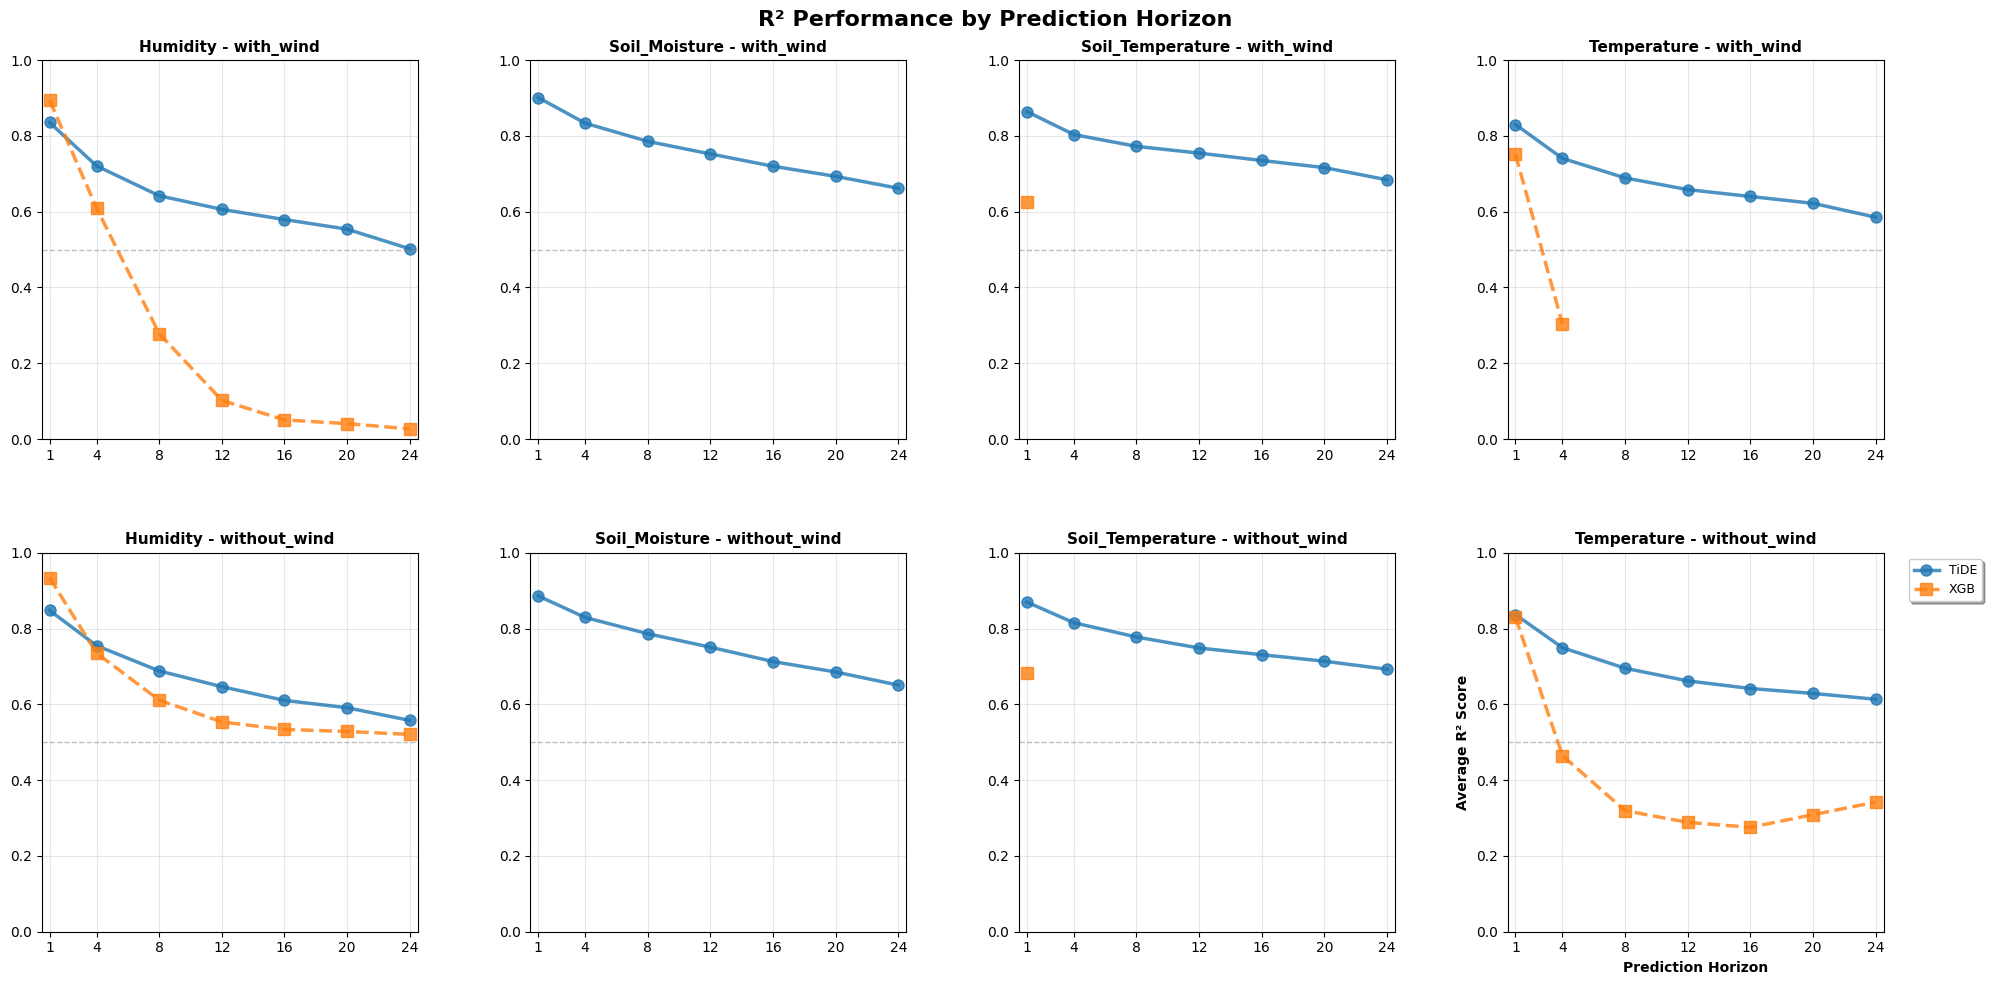

Combined R² line plot saved as: ../final_results_graphs/lines/line_R2_all_combined.png


In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Gráfico de linha para R2 com cores e padrões amigáveis para daltônicos
RESULTS_PATH = '../results/'
models = [d for d in os.listdir(RESULTS_PATH) if os.path.isdir(os.path.join(RESULTS_PATH, d))]
variants = ['with_wind', 'without_wind']
horizons = [1, 4, 8, 12, 16, 20, 24]

# Coleta os dados de R2 por horizonte
r2_data = []
for model in models:
    for variant in variants:
        filepath = f'{RESULTS_PATH}{model}/{variant}/all_metrics_horizon.json'
        if not os.path.exists(filepath):
            continue
        with open(filepath, 'r') as f:
            data_by_fold = json.load(f)
        for fold_idx, horizon_list in enumerate(data_by_fold):
            for horizon_idx, all_metrics in enumerate(horizon_list):
                if horizon_idx >= len(horizons):
                    continue
                horizon_value = horizons[horizon_idx]
                if 'R2' not in all_metrics:
                    continue
                feature_metrics = all_metrics['R2']
                for feature, value in feature_metrics.items():
                    r2_data.append({
                        'model': model,
                        'variant': variant,
                        'horizon': horizon_value,
                        'feature': feature,
                        'r2_value': value
                    })

if r2_data:
    df_r2 = pd.DataFrame(r2_data)
    # Média por modelo, variante, horizonte e feature
    avg_r2_df = df_r2.groupby(['model', 'variant', 'horizon', 'feature']).agg(
        avg_r2=('r2_value', 'mean')
    ).reset_index()
    
    # Filtrar grupos com pelo menos 2 pontos para evitar erro de plotagem
    grouping_cols = ['model', 'variant', 'feature']
    counts = avg_r2_df.groupby(grouping_cols)['horizon'].transform('count')
    plottable_df = avg_r2_df[counts > 1]
    
    # Filtrar apenas valores R² válidos (0 a 1) e remover combinações vazias
    plottable_df = plottable_df[(plottable_df['avg_r2'] >= 0) & (plottable_df['avg_r2'] <= 1)]
    
    # Verificar se ainda há combinações válidas após o filtro
    valid_combinations = []
    for (variant, feature), group in plottable_df.groupby(['variant', 'feature']):
        if len(group) > 1:  # Precisa de pelo menos 2 pontos para fazer um gráfico de linha
            valid_combinations.append((variant, feature))
    
    if not valid_combinations:
        print("Not enough valid R2 data (0-1 range) to plot. Skipping.")
    else:
        # Filtrar o DataFrame para incluir apenas as combinações válidas
        plottable_df = plottable_df[plottable_df.apply(lambda x: (x['variant'], x['feature']) in valid_combinations, axis=1)]
        # Cores distintas amigáveis para daltônicos
        colorblind_colors = [
            '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
            '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
            '#bcbd22', '#17becf', '#aec7e8', '#ffbb78'
        ]
        
        # Padrões de linha distintos
        line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
        markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', '+']
        
        # Para cada combinação válida de variante e feature, criar subplots em uma única figura
        combinations = valid_combinations
        n_plots = len(combinations)
        n_cols = 4  # 4 gráficos por linha
        n_rows = (n_plots + n_cols - 1) // n_cols  # Divisão arredondada para cima
        
        # Criar uma única figura com todos os subplots
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
        
        # Garantir que axes seja sempre 2D
        if n_rows == 1 and n_cols == 1:
            axes = np.array([[axes]])
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        # Ocultar todos os eixos extras que não serão usados
        for i in range(n_rows):
            for j in range(n_cols):
                if i * n_cols + j >= n_plots:
                    axes[i, j].set_visible(False)
        
        # Determinar o subplot mais isolado (último) para a legenda
        last_plot_idx = n_plots - 1
        legend_row = last_plot_idx // n_cols
        legend_col = last_plot_idx % n_cols
        
        for plot_idx, (variant, feature) in enumerate(combinations):
            i = plot_idx // n_cols  # Linha
            j = plot_idx % n_cols   # Coluna
            ax = axes[i, j]
            
            group = plottable_df[(plottable_df['variant'] == variant) & 
                                (plottable_df['feature'] == feature)]
            
            unique_models = sorted(group['model'].unique())
            
            for k, model in enumerate(unique_models):
                model_data = group[group['model'] == model]
                
                ax.plot(model_data['horizon'], model_data['avg_r2'],
                        color=colorblind_colors[k % len(colorblind_colors)],
                        linestyle=line_styles[k % len(line_styles)],
                        marker=markers[k % len(markers)],
                        linewidth=2.5,
                        markersize=8,
                        label=model,
                        alpha=0.8)
            
            # Labels apenas no último subplot
            if plot_idx == last_plot_idx:
                ax.set_xlabel('Prediction Horizon', fontsize=10, fontweight='bold')
                ax.set_ylabel('Average R² Score', fontsize=10, fontweight='bold')
            else:
                ax.set_xlabel('')
                ax.set_ylabel('')
                
            ax.set_title(f'{feature} - {variant}', fontsize=11, fontweight='bold')
            
            # Configurar eixos
            ax.set_xlim(0.5, 24.5)
            ax.set_ylim(0, 1)  # R2 range de 0 a 1 apenas
            ax.set_xticks(horizons)
            ax.grid(True, alpha=0.3)
            
            # Adicionar linha de referência em y=0.5 (meio da escala)
            ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
            
            # Legenda apenas no subplot mais isolado (último)
            if plot_idx == last_plot_idx:
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                         frameon=True, fancybox=True, shadow=True, fontsize=9)
        
        plt.suptitle('R² Performance by Prediction Horizon', 
                    fontsize=16, fontweight='bold', y=0.98)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.93, hspace=0.3, wspace=0.3)
        
        # Salvar o gráfico único
        plt.savefig('../final_results_graphs/lines/line_R2_all_combined.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f'Combined R² line plot saved as: ../final_results_graphs/lines/line_R2_all_combined.png')
else:
    print('No R2 horizon data found to generate plots.')

In [5]:
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import os
from matplotlib.colors import LogNorm, Normalize

# Caminhos dos arquivos avg_metrics.json
avg_metrics_files = glob.glob(os.path.join(RESULTS_PATH, '*', '*', 'avg_metrics.json'))

metricas = []
for file in avg_metrics_files:
    parts = file.split(os.sep)
    model = parts[-3]
    variant = parts[-2]
    with open(file, 'r') as f:
        data = json.load(f)
    for metric, features in data.items():
        for feature, value in features.items():
            metricas.append({
                'model': model,
                'variant': variant,
                'feature': feature,
                'metric': metric,
                'value': value
            })

if metricas:
    df = pd.DataFrame(metricas)
    # Substitui inf e -inf por NaN
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['value'].replace([np.inf, -np.inf], np.nan, inplace=True)
    print('Features únicas:', df['feature'].unique())
    print('Modelos únicos:', df['model'].unique())
    print('Variantes únicas:', df['variant'].unique())
    # Descobre o range global de SMAPE
    smape_df = df[df['metric'] == 'SMAPE']
    smape_vmin = smape_df['value'].min()
    smape_vmax = smape_df['value'].max()
    for metric in df['metric'].unique():
        for variant in df['variant'].unique():
            sub = df[(df['metric'] == metric) & (df['variant'] == variant)]
            if sub.empty:
                continue
            pivot = sub.pivot(index='feature', columns='model', values='value')
            print(f'\nMétrica: {metric} | Variante: {variant}')
            print(pivot)
            # Só plota se houver pelo menos um valor válido
            if pivot.notna().sum().sum() == 0:
                print(f"Sem dados válidos para {metric} - {variant}, gráfico não exibido.")
                continue
            mask = pivot.isna()
            data_vals = pivot.values[~mask.values]
            plt.figure(figsize=(12, 6))
            if metric == 'R2':
                display_pivot = pivot.copy()
                display_pivot = display_pivot.clip(-1, 1)
                annot = display_pivot.round(2).astype(str)
                annot[pivot <= -1] = '≤ -1'
                sns.heatmap(display_pivot, annot=annot, fmt='', cmap='RdBu_r', center=0, annot_kws={"size":12}, cbar_kws={"shrink":0.8}, mask=mask, vmin=-1, vmax=1)
                plt.title(f'Heatmap of {metric} (-1 ≤ x ≤ 1) - {variant}', fontsize=16)
            elif metric == 'SMAPE':
                sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdBu_r', vmin=smape_vmin, vmax=smape_vmax, center=0, annot_kws={"size":12}, cbar_kws={"shrink":0.8}, mask=mask)
                plt.title(f'Heatmap of {metric} - {variant}', fontsize=16)
            else:
                sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdBu_r', center=0, annot_kws={"size":12}, cbar_kws={"shrink":0.8}, mask=mask)
                plt.title(f'Heatmap of {metric} - {variant}', fontsize=16)
            plt.ylabel('Feature', fontsize=14)
            plt.xlabel('Model', fontsize=14)
            plt.xticks(rotation=45, ha='right', fontsize=12)
            plt.yticks(rotation=0, fontsize=12)
            plt.tight_layout()
            plt.savefig(f'../final_results_graphs/heatmaps_per_metric/heatmap_{metric}_{variant}.png', dpi=300, bbox_inches='tight')
else:
    print('No avg_metrics.json files found or no data to plot.')


/tmp/ipykernel_1769/2479501083.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




Features únicas: ['Temperature' 'Humidity' 'Wind_Speed_kmh' 'Soil_Moisture'
 'Soil_Temperature' 'Wind_Dir_Sin' 'Wind_Dir_Cos'
 'Precipitation_accumulated']
Modelos únicos: ['Transformer' 'XGB' 'TSMixer' 'TiDE' 'GRU' 'LSTM' 'NHiTS' 'TCN']
Variantes únicas: ['with_wind' 'without_wind']

Métrica: MSE | Variante: with_wind
model                                GRU           LSTM         NHiTS  \
feature                                                                 
Humidity                      586.324535     337.796914  3.013340e+02   
Precipitation_accumulated   12199.463504   12251.125510  1.493597e+04   
Soil_Moisture              530660.678902  463633.699792  1.285858e+06   
Soil_Temperature               33.507565      33.212620  4.139428e+01   
Temperature                    51.405268      21.159921  7.039788e+02   
Wind_Dir_Cos                    0.516213       0.333163  3.423383e-01   
Wind_Dir_Sin                    0.525692       0.320206  1.275844e+00   
Wind_Speed_kmh        

/tmp/ipykernel_1769/2479501083.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



Métrica: SMAPE | Variante: without_wind
model                            GRU       LSTM      NHiTS        TCN  \
feature                                                                 
Humidity                   12.836588  12.513317  27.653358  21.275852   
Precipitation_accumulated  17.407382  27.613950  54.758179  20.579636   
Soil_Moisture               6.263782   8.725980  25.696127  15.485325   
Soil_Temperature           40.092027  37.718142  50.893236  47.876235   
Temperature                30.132999  31.599227  53.001603  40.661525   

model                        TSMixer       TiDE  Transformer        XGB  
feature                                                                  
Humidity                   13.651748   5.481162    14.631303   5.946887  
Precipitation_accumulated  20.334655   1.645236    27.768058  18.885030  
Soil_Moisture               9.246215   1.596346     8.084312   4.229948  
Soil_Temperature           45.239128  13.184803    39.134643  20.524891  
Tem

In [6]:
import glob
import json
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

# Caminhos dos arquivos avg_metrics.json
avg_metrics_files = glob.glob(os.path.join(RESULTS_PATH, '*', '*', 'avg_metrics.json'))

heatmap_data = []
for file in avg_metrics_files:
    parts = file.split(os.sep)
    model = parts[-3]
    variant = parts[-2]
    with open(file, 'r') as f:
        data = json.load(f)
    for metric, features in data.items():
        for feature, value in features.items():
            heatmap_data.append({
                'model': model,
                'variant': variant,
                'metric': metric,
                'feature': feature,
                'value': value
            })

if heatmap_data:
    df = pd.DataFrame(heatmap_data)
    for feature in df['feature'].unique():
        for metric in df['metric'].unique():
            sub = df[(df['feature'] == feature) & (df['metric'] == metric)]
            if sub.empty:
                continue
            pivot = sub.pivot(index='model', columns='variant', values='value')
            mask = pivot.isna()
            data_vals = pivot.values[~mask.values]
            use_log = np.all((data_vals > 0) & np.isfinite(data_vals)) and data_vals.size > 0
            plt.figure(figsize=(8, 5))
            if metric == 'R2':
                display_pivot = pivot.copy().clip(-1, 1)
                annot = display_pivot.round(2).astype(str)
                annot[pivot <= -1] = '≤ -1'
                sns.heatmap(display_pivot, annot=annot, fmt='', cmap='YlGnBu', center=0, annot_kws={"size":12}, cbar_kws={"shrink":0.8}, mask=mask, vmin=-1, vmax=1)
                plt.title(f'Heatmap (R2: -1 ≤ x ≤ 1) - {feature} - {metric}')
            elif use_log:
                sns.heatmap(pivot, annot=True, fmt='.2e', cmap='YlGnBu', norm=LogNorm(), annot_kws={"size":12}, cbar_kws={"shrink":0.8}, mask=mask)
                plt.title(f'Heatmap (log color) - {feature} - {metric}')
            else:
                sns.heatmap(pivot, annot=True, fmt='.2e', cmap='YlGnBu', annot_kws={"size":12}, cbar_kws={"shrink":0.8}, mask=mask)
                plt.title(f'Heatmap - {feature} - {metric}')
            plt.ylabel('Modelo')
            plt.xlabel('Variante')
            plt.tight_layout()
            plt.savefig(f'../final_results_graphs/heatmaps_per_metric_var/heatmap_{feature}_{metric}.png', dpi=300, bbox_inches='tight')
else:
    print('No avg_metrics.json files found or no data to plot.')

/tmp/ipykernel_2035/379848291.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


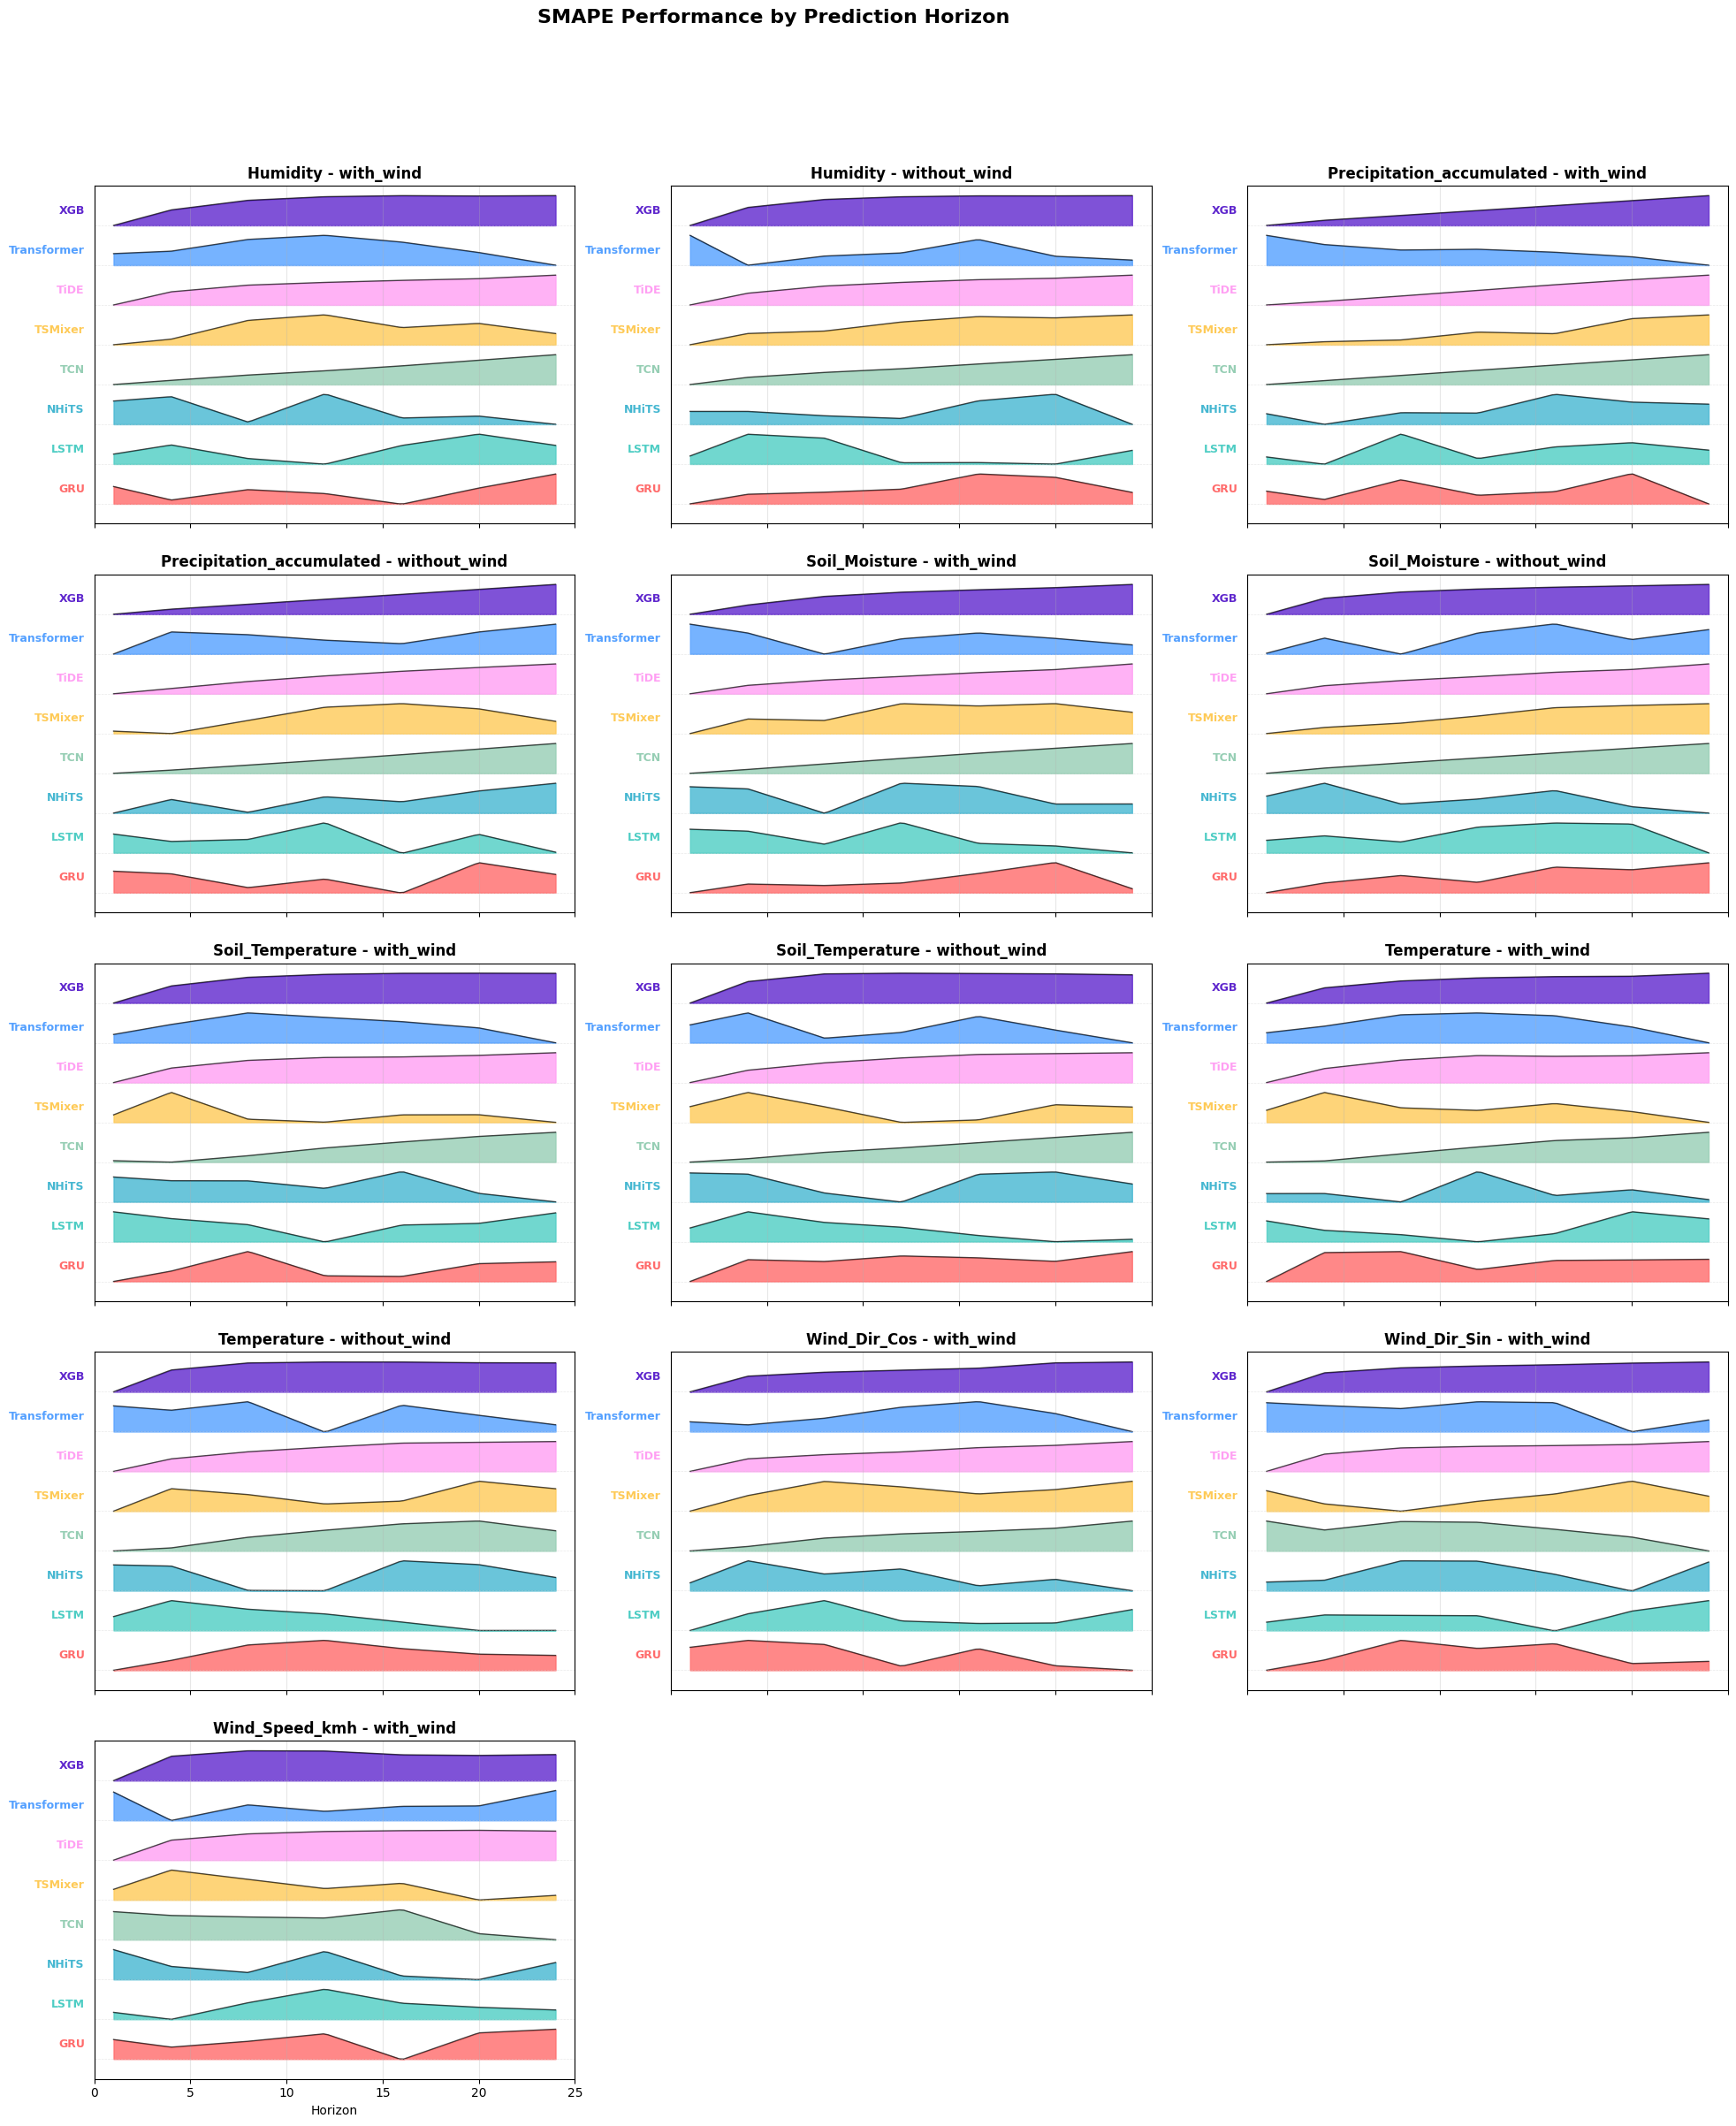

Joyplot saved at: ../final_results_graphs/joyplot_smape_facet_grid.png


In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Polygon

# Preparação dos dados para o joyplot
RESULTS_PATH = '../results/'
models = [d for d in os.listdir(RESULTS_PATH) if os.path.isdir(os.path.join(RESULTS_PATH, d))]
variants = ['with_wind', 'without_wind']
horizons = [1, 4, 8, 12, 16, 20, 24]

# Coleta dados SMAPE por horizonte
joyplot_data = []
for model in models:
    for variant in variants:
        filepath = f'{RESULTS_PATH}{model}/{variant}/all_metrics_horizon.json'
        if not os.path.exists(filepath):
            continue
        with open(filepath, 'r') as f:
            data_by_fold = json.load(f)
        for fold_idx, horizon_list in enumerate(data_by_fold):
            for horizon_idx, all_metrics in enumerate(horizon_list):
                if horizon_idx >= len(horizons):
                    continue
                horizon_value = horizons[horizon_idx]
                if 'SMAPE' not in all_metrics:
                    continue
                feature_metrics = all_metrics['SMAPE']
                for feature, value in feature_metrics.items():
                    joyplot_data.append({
                        'model': model,
                        'weather_variable': feature,  # Renomeando para seguir a especificação
                        'wind_condition': 'with_wind' if variant == 'with_wind' else 'without_wind',
                        'horizon': horizon_value,
                        'smape': value
                    })

if joyplot_data:
    df_joy = pd.DataFrame(joyplot_data)
    
    # Criar mapeamento de cores distintas para modelos
    unique_models = sorted(df_joy['model'].unique())
    # Usar uma paleta de cores distintas e vibrantes
    distinct_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3', '#54A0FF', '#5F27CD']
    colors = distinct_colors[:len(unique_models)]  # Pegar apenas as cores necessárias
    if len(unique_models) > len(distinct_colors):
        # Se tiver mais modelos que cores, usar paleta automática
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_models)))
    model_colors = dict(zip(unique_models, colors))
    
    # Obter combinações únicas de weather_variable e wind_condition que têm dados
    variables = sorted(df_joy['weather_variable'].unique())
    conditions = sorted(df_joy['wind_condition'].unique())
    
    # Filtrar apenas combinações que têm dados
    valid_combinations = []
    for var in variables:
        for cond in conditions:
            subset = df_joy[(df_joy['weather_variable'] == var) & 
                           (df_joy['wind_condition'] == cond)]
            if not subset.empty:
                valid_combinations.append((var, cond))
    
    if not valid_combinations:
        print('No valid combination found.')
    else:
        # Calcular layout dinâmico - 3 colunas por linha
        n_plots = len(valid_combinations)
        n_cols = min(3, n_plots)  # Máximo 3 colunas
        n_rows = (n_plots + n_cols - 1) // n_cols  # Divisão arredondada para cima
        
        # Criar figure com subplots apenas para o número necessário
        fig, axes = plt.subplots(n_rows, n_cols, 
                                figsize=(8 * n_cols, 5 * n_rows),  # Aumentar espaçamento em X
                                sharex=True)
        
        # Garantir que axes seja sempre 2D
        if n_rows == 1 and n_cols == 1:
            axes = np.array([[axes]])
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        # Ocultar todos os eixos extras que não serão usados
        for i in range(n_rows):
            for j in range(n_cols):
                if i * n_cols + j >= n_plots:
                    axes[i, j].set_visible(False)
        
        # Plotar apenas as combinações válidas
        for plot_idx, (var, cond) in enumerate(valid_combinations):
            i = plot_idx // n_cols  # Linha
            j = plot_idx % n_cols   # Coluna
            ax = axes[i, j]
            
            # Filtrar dados para esta combinação
            subset = df_joy[(df_joy['weather_variable'] == var) & 
                           (df_joy['wind_condition'] == cond)]
            
            # Criar ridge plot (joyplot)
            models_in_subset = sorted(subset['model'].unique())
            
            for k, model in enumerate(models_in_subset):
                model_data = subset[subset['model'] == model]
                
                if len(model_data) > 1:
                    # Criar densidade KDE para cada horizonte
                    horizon_values = []
                    smape_values = []
                    
                    for horizon in sorted(model_data['horizon'].unique()):
                        horizon_data = model_data[model_data['horizon'] == horizon]['smape']
                        horizon_values.extend([horizon] * len(horizon_data))
                        smape_values.extend(horizon_data.values)
                    
                    if len(set(horizon_values)) > 1:  # Precisa de pelo menos 2 horizontes diferentes
                        # Criar uma "crista" para este modelo
                        x_vals = sorted(set(horizon_values))
                        y_vals = []
                        
                        for horizon in x_vals:
                            horizon_smape = [s for h, s in zip(horizon_values, smape_values) if h == horizon]
                            y_vals.append(np.mean(horizon_smape))
                        
                        # Normalizar y_vals para criar altura da crista
                        y_offset = k * 0.4  # Espaçamento vertical entre modelos
                        ridge_height = 0.3  # Altura máxima da crista
                        
                        if len(y_vals) > 1:
                            # Criar linha suavizada
                            from scipy.interpolate import interp1d
                            if len(x_vals) >= 2:
                                f = interp1d(x_vals, y_vals, kind='linear')
                                x_smooth = np.linspace(min(x_vals), max(x_vals), 100)
                                y_smooth = f(x_smooth)
                                
                                # Normalizar para altura da crista (direto - menor SMAPE = crista mais baixa)
                                y_normalized = (y_smooth - np.min(y_smooth)) / (np.max(y_smooth) - np.min(y_smooth)) if np.max(y_smooth) != np.min(y_smooth) else np.ones_like(y_smooth)
                                y_ridge = y_offset + y_normalized * ridge_height
                                
                                # Plotar a crista
                                ax.fill_between(x_smooth, y_offset, y_ridge, 
                                               alpha=0.8, color=model_colors[model])
                                ax.plot(x_smooth, y_ridge, color='black', linewidth=1, alpha=0.7)
                else:
                    # Apenas um ponto - plotar como linha horizontal
                    ax.axhline(y=k * 0.4, xmin=0.1, xmax=0.9, color=model_colors[model], 
                              alpha=0.8, linewidth=4)
            
            # Adicionar labels dos modelos no eixo Y, alinhados com as cristas
            for k, model in enumerate(models_in_subset):
                y_pos = k * 0.4 + 0.15  # Mesma posição vertical das cristas
                ax.text(-0.5, y_pos, model, 
                       verticalalignment='center', fontsize=9, fontweight='bold',
                       color=model_colors[model], ha='right')
            
            # Configurar eixos e títulos
            ax.set_xlabel('Horizon' if i == n_rows - 1 else '')
            ax.set_ylabel('')  # Remover label "Models"
            ax.set_title(f'{var} - {cond}', fontsize=12, fontweight='bold')
            ax.set_ylim(-0.2, len(models_in_subset) * 0.4)
            ax.set_yticks([])  # Remover ticks do Y
            ax.grid(True, alpha=0.3, axis='x')
            ax.set_xlim(df_joy['horizon'].min() - 1, df_joy['horizon'].max() + 1)  # Mais espaço em X
            
            # Adicionar linha base para separar os modelos
            for k in range(len(models_in_subset)):
                ax.axhline(y=k * 0.4, color='lightgray', linewidth=0.5, alpha=0.5, linestyle='--')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.88, left=0.18, right=0.95, hspace=0.15, wspace=0.2)  # Reduzido espaço entre gráficos
        
        # Adicionar título principal
        plt.suptitle('SMAPE Performance by Prediction Horizon', 
                    fontsize=16, fontweight='bold', y=1)
        
        # Salvar o gráfico
        plt.savefig('../final_results_graphs/joyplot_smape_facet_grid.png', 
                    dpi=300, bbox_inches='tight')
        plt.show()
        
        print('Joyplot saved at: ../final_results_graphs/joyplot_smape_facet_grid.png')
else:
    print('No data found to create the joyplot.')

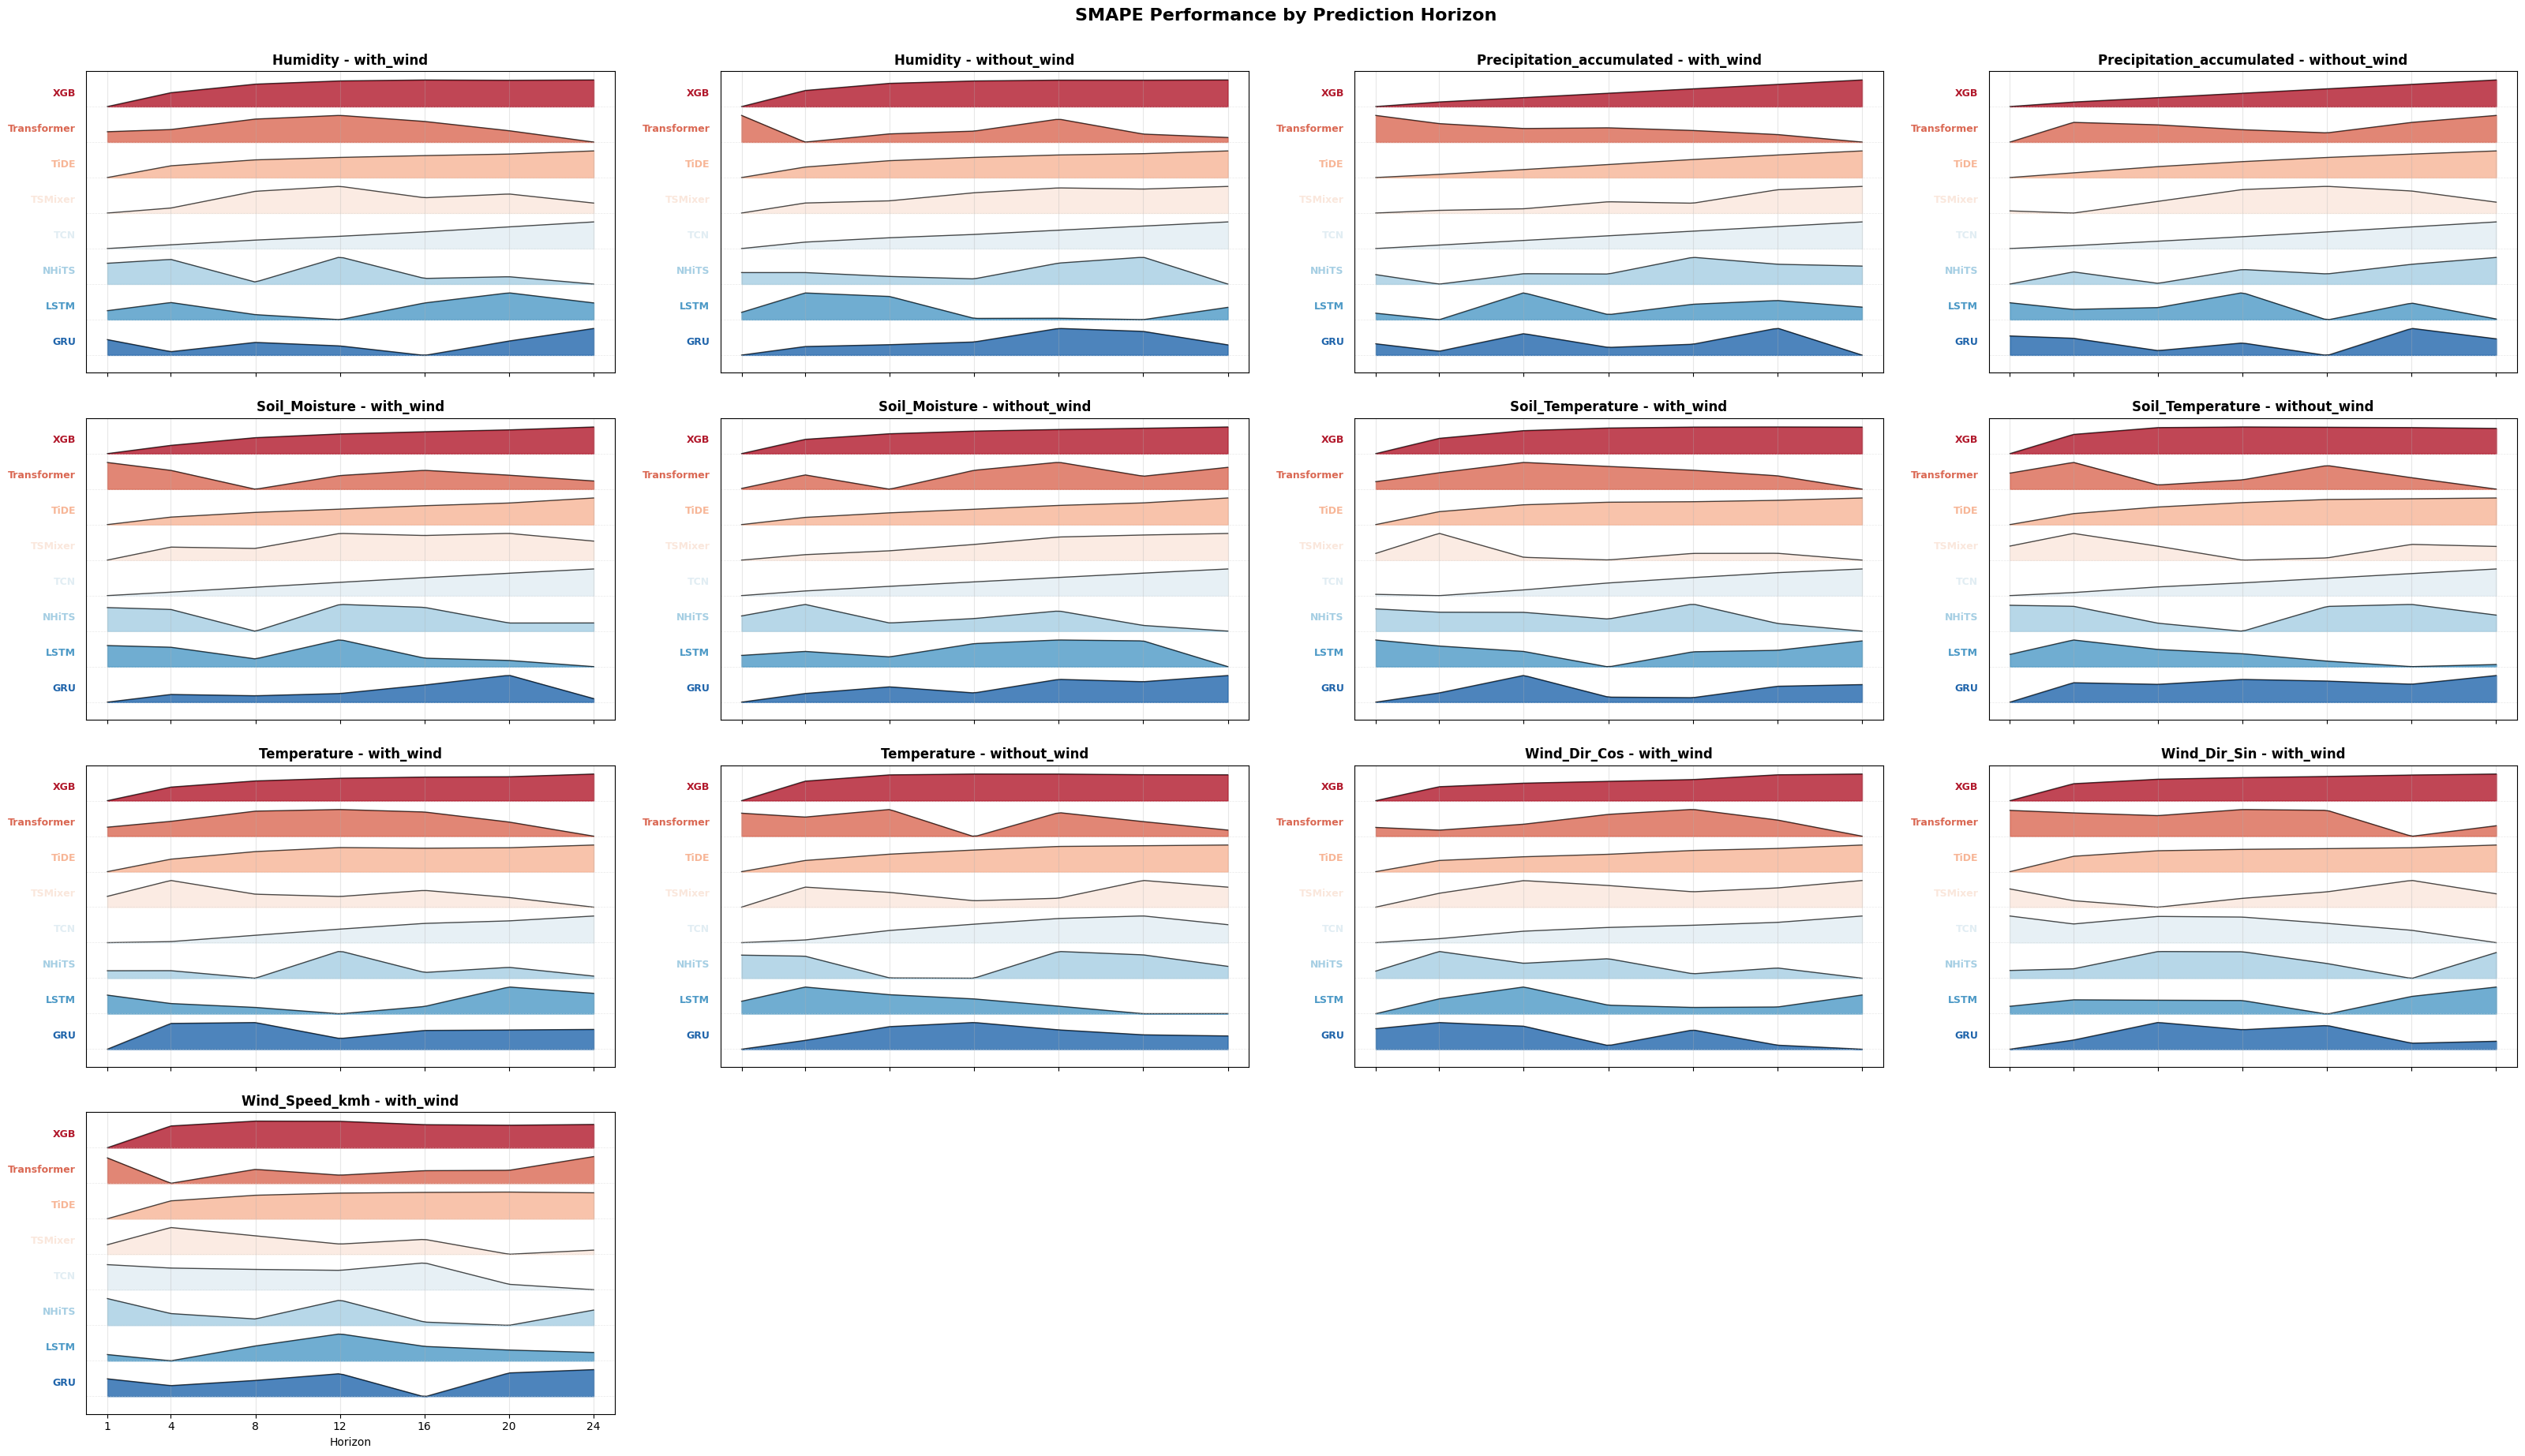

Joyplot saved at: ../final_results_graphs/joyplot_smape_facet_grid.png


In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Polygon

# Preparação dos dados para o joyplot
RESULTS_PATH = '../results/'
models = [d for d in os.listdir(RESULTS_PATH) if os.path.isdir(os.path.join(RESULTS_PATH, d))]
variants = ['with_wind', 'without_wind']
horizons = [1, 4, 8, 12, 16, 20, 24]

# Coleta dados SMAPE por horizonte
joyplot_data = []
for model in models:
    for variant in variants:
        filepath = f'{RESULTS_PATH}{model}/{variant}/all_metrics_horizon.json'
        if not os.path.exists(filepath):
            continue
        with open(filepath, 'r') as f:
            data_by_fold = json.load(f)
        for fold_idx, horizon_list in enumerate(data_by_fold):
            for horizon_idx, all_metrics in enumerate(horizon_list):
                if horizon_idx >= len(horizons):
                    continue
                horizon_value = horizons[horizon_idx]
                if 'SMAPE' not in all_metrics:
                    continue
                feature_metrics = all_metrics['SMAPE']
                for feature, value in feature_metrics.items():
                    joyplot_data.append({
                        'model': model,
                        'weather_variable': feature,  # Renomeando para seguir a especificação
                        'wind_condition': 'with_wind' if variant == 'with_wind' else 'without_wind',
                        'horizon': horizon_value,
                        'smape': value
                    })

if joyplot_data:
    df_joy = pd.DataFrame(joyplot_data)
    
    # Criar mapeamento de cores distintas para modelos usando paleta RdBu_r
    unique_models = sorted(df_joy['model'].unique())
    # Usar paleta RdBu_r (colormap amigável para daltônicos)
    colors = plt.cm.RdBu_r(np.linspace(0.1, 0.9, len(unique_models)))  # Evitar extremos para melhor contraste
    model_colors = dict(zip(unique_models, colors))
    
    # Obter combinações únicas de weather_variable e wind_condition que têm dados
    variables = sorted(df_joy['weather_variable'].unique())
    conditions = sorted(df_joy['wind_condition'].unique())
    
    # Filtrar apenas combinações que têm dados
    valid_combinations = []
    for var in variables:
        for cond in conditions:
            subset = df_joy[(df_joy['weather_variable'] == var) & 
                           (df_joy['wind_condition'] == cond)]
            if not subset.empty:
                valid_combinations.append((var, cond))
    
    if not valid_combinations:
        print('No valid combination found.')
    else:
        # Calcular layout dinâmico - 4 colunas por linha
        n_plots = len(valid_combinations)
        n_cols = min(4, n_plots)  # Máximo 4 colunas
        n_rows = (n_plots + n_cols - 1) // n_cols  # Divisão arredondada para cima
        
        # Criar figure com subplots apenas para o número necessário
        fig, axes = plt.subplots(n_rows, n_cols, 
                                figsize=(10 * n_cols, 5 * n_rows),  # Aumentar espaçamento em X
                                sharex=True)
        
        # Garantir que axes seja sempre 2D
        if n_rows == 1 and n_cols == 1:
            axes = np.array([[axes]])
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        # Ocultar todos os eixos extras que não serão usados
        for i in range(n_rows):
            for j in range(n_cols):
                if i * n_cols + j >= n_plots:
                    axes[i, j].set_visible(False)
        
        # Plotar apenas as combinações válidas
        for plot_idx, (var, cond) in enumerate(valid_combinations):
            i = plot_idx // n_cols  # Linha
            j = plot_idx % n_cols   # Coluna
            ax = axes[i, j]
            
            # Filtrar dados para esta combinação
            subset = df_joy[(df_joy['weather_variable'] == var) & 
                           (df_joy['wind_condition'] == cond)]
            
            # Criar ridge plot (joyplot)
            models_in_subset = sorted(subset['model'].unique())
            
            for k, model in enumerate(models_in_subset):
                model_data = subset[subset['model'] == model]
                
                if len(model_data) > 1:
                    # Criar densidade KDE para cada horizonte
                    horizon_values = []
                    smape_values = []
                    
                    for horizon in sorted(model_data['horizon'].unique()):
                        horizon_data = model_data[model_data['horizon'] == horizon]['smape']
                        horizon_values.extend([horizon] * len(horizon_data))
                        smape_values.extend(horizon_data.values)
                    
                    if len(set(horizon_values)) > 1:  # Precisa de pelo menos 2 horizontes diferentes
                        # Criar uma "crista" para este modelo
                        x_vals = sorted(set(horizon_values))
                        y_vals = []
                        
                        for horizon in x_vals:
                            horizon_smape = [s for h, s in zip(horizon_values, smape_values) if h == horizon]
                            y_vals.append(np.mean(horizon_smape))
                        
                        # Normalizar y_vals para criar altura da crista
                        y_offset = k * 0.4  # Espaçamento vertical entre modelos
                        ridge_height = 0.3  # Altura máxima da crista
                        
                        if len(y_vals) > 1:
                            # Criar linha suavizada
                            from scipy.interpolate import interp1d
                            if len(x_vals) >= 2:
                                f = interp1d(x_vals, y_vals, kind='linear')
                                x_smooth = np.linspace(min(x_vals), max(x_vals), 100)
                                y_smooth = f(x_smooth)
                                
                                # Normalizar para altura da crista (direto - menor SMAPE = crista mais baixa)
                                y_normalized = (y_smooth - np.min(y_smooth)) / (np.max(y_smooth) - np.min(y_smooth)) if np.max(y_smooth) != np.min(y_smooth) else np.ones_like(y_smooth)
                                y_ridge = y_offset + y_normalized * ridge_height
                                
                                # Plotar a crista
                                ax.fill_between(x_smooth, y_offset, y_ridge, 
                                               alpha=0.8, color=model_colors[model])
                                ax.plot(x_smooth, y_ridge, color='black', linewidth=1, alpha=0.7)
                else:
                    # Apenas um ponto - plotar como linha horizontal
                    ax.axhline(y=k * 0.4, xmin=0.1, xmax=0.9, color=model_colors[model], 
                              alpha=0.8, linewidth=4)
            
            # Adicionar labels dos modelos no eixo Y, alinhados com as cristas
            for k, model in enumerate(models_in_subset):
                y_pos = k * 0.4 + 0.15  # Mesma posição vertical das cristas
                ax.text(-0.5, y_pos, model, 
                       verticalalignment='center', fontsize=9, fontweight='bold',
                       color=model_colors[model], ha='right')
            
            # Configurar eixos e títulos
            ax.set_xlabel('Horizon' if i == n_rows - 1 else '')
            ax.set_ylabel('')  # Remover label "Models"
            ax.set_title(f'{var} - {cond}', fontsize=12, fontweight='bold')
            ax.set_ylim(-0.2, len(models_in_subset) * 0.4)
            ax.set_yticks([])  # Remover ticks do Y
            ax.grid(True, alpha=0.3, axis='x')
            ax.set_xlim(df_joy['horizon'].min() - 1, df_joy['horizon'].max() + 1)  # Mais espaço em X
            ax.set_xticks([1, 4, 8, 12, 16, 20, 24])  # Pontos específicos no eixo X
            
            # Adicionar linha base para separar os modelos
            for k in range(len(models_in_subset)):
                ax.axhline(y=k * 0.4, color='lightgray', linewidth=0.5, alpha=0.5, linestyle='--')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.88, left=0.18, right=0.95, hspace=0.15, wspace=0.2)  # Reduzido espaço entre gráficos
        
        # Adicionar título principal
        plt.suptitle('SMAPE Performance by Prediction Horizon', 
                    fontsize=16, fontweight='bold', y=0.92, x=0.56)
        
        # Salvar o gráfico
        plt.savefig('../final_results_graphs/joyplot_smape_facet_grid.png', 
                    dpi=300, bbox_inches='tight')
        plt.show()
        
        print('Joyplot saved at: ../final_results_graphs/joyplot_smape_facet_grid.png')
else:
    print('No data found to create the joyplot.')